# BioBERT Dual Lifestyle Classifier

This notebook demonstrates the BioBERT classification pipeline for distinguishing between dual and solo lifestyles in biological abstracts.

## 1. Data Loading and Preprocessing

Load the training and test datasets, and show the train/test split.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Display basic info
print('Training set shape:', train_df.shape)
print('Test set shape:', test_df.shape)
print('\nTraining set class distribution:')
print(train_df['label'].value_counts())
print('\nTest set class distribution:')
print(test_df['label'].value_counts())

# Show sample data
print('\nSample training data:')
print(train_df.head())
print('\nSample test data:')
print(test_df.head())

Training set shape: (34, 4)
Test set shape: (22, 4)

Training set class distribution:
label
1    18
0    16
Name: count, dtype: int64

Test set class distribution:
label
0    12
1    10
Name: count, dtype: int64

Sample training data:
                                       abstract_text  label  \
0  Alternaria alternata is a common species of fu...      1   
1  Schizophyllum commune is a mushroom forming ba...      1   
2  Over the past 10 years evidence has increased ...      0   
3  Endophytes typically coexist with plants in sy...      1   
4  Summary Some soil fungi in the Leotiomycetes f...      1   

                                               title keywords  
0     Alternaria alternata as endophyte and pathogen    comps  
1  The versatility of {Schizophyllum} commune in ...      NaN  
2  Confirmation that {Phytophthora} insolita ({Pe...      NaN  
3  Tracing microbial community across endophyte-t...      NaN  
4  Comparative genomics and transcriptomics depic...      NaN  

S

## 2. Model Fine-tuning with Training Curves

Load the fine-tuned BioBERT model and display training curves.

c:\Users\beabo\miniconda3\envs\nlp_bio\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Checking if model exists at: fine_tuned_biobert_classification
Model directory exists: True
Checking if trainer_state exists at: results/trainer_state.json
Trainer state file exists: False
Trainer state does not exist. Trying alternative path...
Using latest checkpoint: results_classification\checkpoint-8\trainer_state.json
Log history length: 2
Sample log entries:
Entry 0: {'epoch': 1.0, 'eval_accuracy': 0.5714285714285714, 'eval_loss': 0.6819667220115662, 'eval_runtime': 4.0775, 'eval_samples_per_second': 1.717, 'eval_steps_per_second': 0.245, 'step': 4}
Entry 1: {'epoch': 2.0, 'eval_accuracy': 0.7142857142857143, 'eval_loss': 0.6486720442771912, 'eval_runtime': 4.3303, 'eval_samples_per_second': 1.617, 'eval_steps_per_second': 0.231, 'step': 8}
Extracting training metrics...
Steps length: 0
Train loss length: 0
Eval loss length: 2
Eval accuracy length: 2
No training loss data to plot. The plot will be empty.


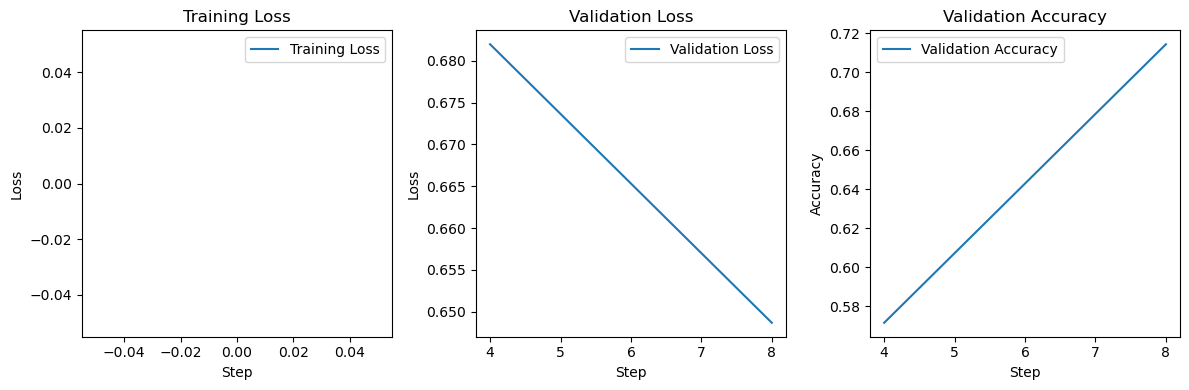

In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer
import json
import matplotlib.pyplot as plt
import os
import glob

# Load the fine-tuned model and tokenizer
model_path = 'fine_tuned_biobert_classification'
print(f"Checking if model exists at: {model_path}")
print(f"Model directory exists: {os.path.exists(model_path)}")
if not os.path.exists(model_path):
    print("Model does not exist. Please train the model first using generate_report.py")
else:
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)

# Load training history from trainer state
trainer_state_path = 'results/trainer_state.json'  # Using the latest checkpoint
print(f"Checking if trainer_state exists at: {trainer_state_path}")
print(f"Trainer state file exists: {os.path.exists(trainer_state_path)}")
if not os.path.exists(trainer_state_path):
    print("Trainer state does not exist. Trying alternative path...")
    # Try the alternative path from generate_report.py
    trainer_state_paths = glob.glob('results_classification/checkpoint-*/trainer_state.json')
    if trainer_state_paths:
        trainer_state_path = sorted(trainer_state_paths)[-1]
        print(f"Using latest checkpoint: {trainer_state_path}")
    else:
        print("No trainer state found. Log history will be empty.")
if os.path.exists(trainer_state_path):
    with open(trainer_state_path, 'r') as f:
        trainer_state = json.load(f)
    # Extract training metrics
    log_history = trainer_state['log_history']
    print(f"Log history length: {len(log_history)}")
    if log_history:
        print("Sample log entries:")
        for i, entry in enumerate(log_history[:5]):
            print(f"Entry {i}: {entry}")
    else:
        print("Log history is empty.")
else:
    log_history = []
    print("Using empty log history.")

# Extract training metrics
# (moved inside the if block above, but keeping here for structure)

# Plot training curves
print("Extracting training metrics...")
steps = [entry.get('step', 0) for entry in log_history if 'loss' in entry]
train_loss = [entry['loss'] for entry in log_history if 'loss' in entry]
eval_loss = [entry.get('eval_loss', None) for entry in log_history if 'eval_loss' in entry]
eval_accuracy = [entry.get('eval_accuracy', None) for entry in log_history if 'eval_accuracy' in entry]
print(f"Steps length: {len(steps)}")
print(f"Train loss length: {len(train_loss)}")
print(f"Eval loss length: {len(eval_loss)}")
print(f"Eval accuracy length: {len(eval_accuracy)}")
if not steps or not train_loss:
    print("No training loss data to plot. The plot will be empty.")
else:
    print("Data available for plotting.")

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(steps, train_loss, label='Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 3, 2)
valid_steps = [entry.get('step', 0) for entry in log_history if 'eval_loss' in entry]
plt.plot(valid_steps, eval_loss, label='Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(valid_steps, eval_accuracy, label='Validation Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()


## 3. Evaluation on Test Set

Evaluate the model on the test set and compute metrics: accuracy, precision, recall, F1.

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import torch
from torch.utils.data import Dataset

# Custom dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Prepare test dataset
test_texts = test_df['abstract'].tolist()
test_labels = test_df['label'].tolist()
test_dataset = TextDataset(test_texts, test_labels, tokenizer)

# Create trainer for evaluation
trainer = Trainer(model=model)

# Get predictions
predictions = trainer.predict(test_dataset)
preds = torch.argmax(torch.tensor(predictions.predictions), axis=1).numpy()
true_labels = test_labels

# Calculate metrics
accuracy = accuracy_score(true_labels, preds)
precision = precision_score(true_labels, preds, average='binary')
recall = recall_score(true_labels, preds, average='binary')
f1 = f1_score(true_labels, preds, average='binary')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('\nClassification Report:')
print(classification_report(true_labels, preds, target_names=['Solo', 'Dual']))

KeyError: 'abstract'

## 4. Example Predictions

Make predictions on example abstracts.

In [ ]:
# Example abstracts
examples = [
    "This fungus can switch between saprotrophic decomposition of dead organic matter and forming mutualistic symbioses with plant roots, demonstrating a dual trophic lifestyle.",
    "This saprotrophic fungus specializes exclusively in decomposing dead plant material and cannot form symbiotic associations.",
    "The pathogenic fungus infects living plants but can also survive saprotrophically on dead plant tissues, exhibiting dual trophic modes.",
    "This obligate symbiont fungus can only survive in mutualistic association with its host plant and cannot decompose dead organic matter independently."
]

# Tokenize and predict
model.eval()
predictions = []
for text in examples:
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()
        predictions.append('Dual' if pred == 1 else 'Solo')

# Display results
for i, (text, pred) in enumerate(zip(examples, predictions)):
    print(f'Example {i+1}: {pred}')
    print(f'Text: {text}')
